<a href="https://colab.research.google.com/github/GamelinAl/mbtrack2_examples/blob/main/mbtrack2_RF_feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook introduces different kinds of **RF loops and feedbacks** for **mbtrack2** which can be used in conjonction with the `CavityResonator` class:
+ The `ProportionalLoop` class, a simple proportional feedback loop used to control the cavity amplitude and phase.
+  The `ProportionalIntegralLoop` class, a more realisitc Proportional Integral (PI) loop which controls the `CavityResonator` amplitude and phase via the generator current to take into account the cavity response.
+ The `TunerLoop` class, used to control a `CavityResonator` tuning angle in order to keep the phase between cavity and generator current constant.
+ The `DirectFeedback` class, based on top of `ProportionalIntegralLoop`, which is used to reduced to effective shunt impedance of the `CavityResonator` seen by the beam.

The features demonstarted in this notebook rely a lot on the `CavityResonator` class, an example notebook for this class is available here: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GamelinAl/mbtrack2_examples/blob/main/mbtrack2_cavity_resonator.ipynb)

## References

[1] : Yamamoto, N., Takahashi, T., & Sakanaka, S. (2018). Reduction and
    compensation of the transient beam loading effect in a double rf system
    of synchrotron light sources. PRAB, 21(1), 012001.

[2] : Akai, K. (2022). Stability analysis of rf accelerating mode with
    feedback loops under heavy beam loading in SuperKEKB. PRAB, 25(10),
    102002.

[3] : N. Yamamoto et al. (2023) Stability survey of a double RF system with RF feedback loops for bunch lengthening in a low-emittance synchrotron ring. In Proc. IPAC'23. doi:10.18429/JACoW-IPAC2023-WEPL161

# Initialization

## mbtrack2 set-up

In [ ]:
! git clone -b develop https://gitlab.synchrotron-soleil.fr/PA/collective-effects/mbtrack2.git

Cloning into 'mbtrack2'...
remote: Enumerating objects: 1883, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 1883 (delta 101), reused 0 (delta 0), pack-reused 1712
Receiving objects: 100% (1883/1883), 1.81 MiB | 4.42 MiB/s, done.
Resolving deltas: 100% (1295/1295), done.


In [ ]:
%cd mbtrack2

/content/mbtrack2


## Define a Synchrotron object

In [ ]:
import numpy as np
import h5py as hp
import matplotlib.pyplot as plt
from tqdm import tqdm
from mbtrack2 import Synchrotron, Electron, Optics, LongitudinalMap, SynchrotronRadiation

In [ ]:
h = 20 # Harmonic number of the accelerator.
L = 100 # Ring circumference in [m].
E0 = 1.5e9 # Nominal (total) energy of the ring in [eV].
particle = Electron() # Particle considered.
ac = 1e-3 # Momentum compaction factor.
U0 = 200e3 # Energy loss per turn in [eV].
tau = np.array([1e-3, 1e-3, 2e-3]) # Horizontal, vertical and longitudinal damping times in [s].
tune = np.array([12.2, 15.3]) # Horizontal and vertical tunes.
emit = np.array([10e-9, 10e-12]) # Horizontal and vertical equilibrium emittance in [m.rad].
sigma_0 = 15e-12 # Natural bunch length in [s].
sigma_delta = 1e-3 # Equilibrium energy spread.
chro = [2.0, 3.0] # Horizontal and vertical (non-normalized) chromaticities.

In [ ]:
local_beta = np.array([3, 2]) # Beta function at the tracking location.
local_alpha = np.array([0, 0]) # Alpha function at the tracking location.
local_dispersion = np.array([0, 0, 0, 0]) # Dispersion function and its derivative at the tracking location.
optics = Optics(local_beta=local_beta, local_alpha=local_alpha,
                  local_dispersion=local_dispersion)

In [ ]:
ring = Synchrotron(h=h, optics=optics, particle=particle, L=L, E0=E0, ac=ac,
                   U0=U0, tau=tau, emit=emit, tune=tune,
                   sigma_delta=sigma_delta, sigma_0=sigma_0, chro=chro)

In [ ]:
print("RF frequency = %.5f MHz"%(ring.f1/1e6))
print("Revolution frequency = %.5f MHz"%(ring.f0/1e6))

RF frequency = 59.95849 MHz
Revolution frequency = 2.99792 MHz


In [ ]:
long = LongitudinalMap(ring) # define the LongitudinalMap element with the ring parameters
rad = SynchrotronRadiation(ring)

## Define starting parameters

In [ ]:
from mbtrack2 import Beam, CavityResonator, CavityMonitor, plot_cavitydata

In [ ]:
def restart(I0=0.001, tot_turns=500):
  fill_ptrn = np.zeros(ring.h)
  fill_ptrn[0:ring.h]=I0/h
  mybeam = Beam(ring)
  mybeam.init_beam(fill_ptrn, mp_per_bunch=1)

  m = 1 # Harmonic number of the cavity
  Rs = 5e6 # Shunt impedance of the cavity in [Ohm], defined as 0.5*Vc*Vc/Pc.
          # If Ncav = 1, used for the total shunt impedance.
          # If Ncav > 1, used for the shunt impedance per cavity.
  Q = 35e3 # Quality factor of the cavity.
  QL = 5e3 # Loaded quality factor of the cavity.
  detune = -100e3 # Detuing of the cavity in [Hz], defined as (fr - m*ring.f1).
  Ncav = 4 # Number of cavities.
  MC = CavityResonator(ring, m, Rs, Q, QL, detune, Ncav=Ncav)

  MC.Vc = 1e6 # Total cavity voltage in [V].
  MC.theta = np.arccos(ring.U0/MC.Vc) # Total cavity phase in [rad].
  MC.set_optimal_detune(I0)
  MC.set_generator(I0)

  if 'MCmon' in globals():
    globals()["MCmon"].close()
    ! rm -f "save.hdf5"
  total_size = int(tot_turns/5)
  MCmon = CavityMonitor("MC", ring, file_name = "save",total_size=total_size, save_every=5, buffer_size=10, mpi_mode=False)

  return mybeam, MC, MCmon

# CavityResonator without loop/feedbacks

## Without beam

Before adding loops and feedbacks, we can have a look at the cavity voltage and phase evolution without beam, i.e. a *frozen* beam without beam longitudinal motion and very low current (1 mA):

In [ ]:
mybeam, MC, MCmon = restart(I0=0.001)

In [ ]:
for i in tqdm(range(500)):
  MC.track(mybeam)
  MCmon.track(mybeam, MC)
meanVc = np.mean(MC.cavity_phasor_record)
print(f"\n Residual error: amplitude {np.round((1-np.abs(meanVc)/MC.Vc)*100,3)} % & phase {np.round((1-np.angle(meanVc)/MC.theta)*100,3)} %")

100%|██████████| 500/500 [00:13<00:00, 37.41it/s]


 Residual error: amplitude 0.0 % & phase 0.001 %


The `CavityResonator` setpoint (`CavityResonator.Vc` for the amplitude and `CavityResonator.theta` for the phase) can be shown along the data from tracking using the `show_objective=True` option of the `plot_cavitydata` function.

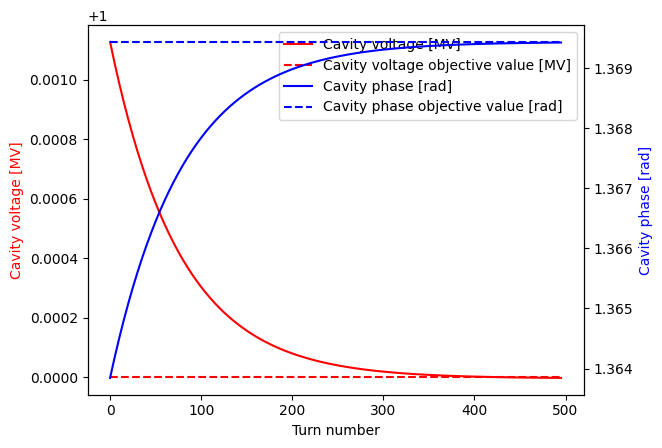

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", show_objective=True)

As there is no loop or feedback, the generator voltage/phase is constant:

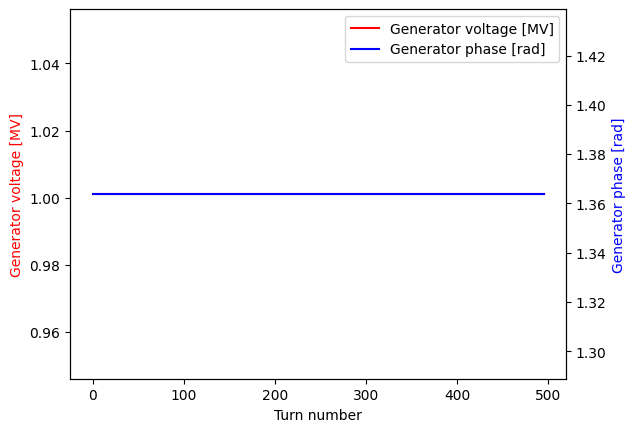

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", phasor="generator")

The beam voltage is nearly zero as the current is very low:

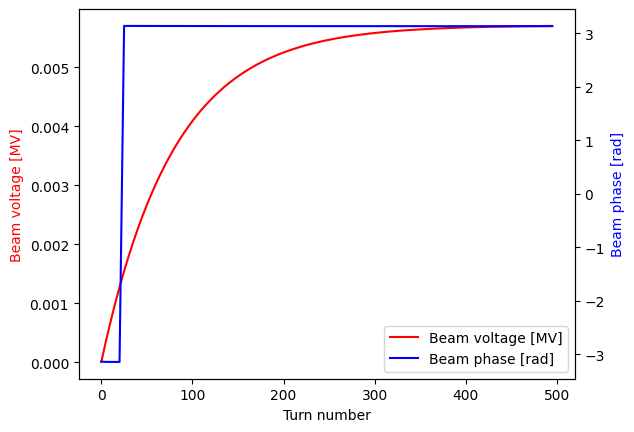

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", phasor="beam")

## With beam

When including longtudinal motion and higher current (200 mA), it takes a bit longer for the cavity voltage and phase to converge to its design value as the beam loading needs to build up:

In [ ]:
mybeam, MC, MCmon = restart(I0=0.2, tot_turns=3000)

In [ ]:
for i in tqdm(range(3000)):
  long.track(mybeam)
  rad.track(mybeam)
  MC.track(mybeam)
  MCmon.track(mybeam, MC)
meanVc = np.mean(MC.cavity_phasor_record)
print(f"\n Residual error: amplitude {np.round((1-np.abs(meanVc)/MC.Vc)*100,3)} % & phase {np.round((1-np.angle(meanVc)/MC.theta)*100,3)} %")

100%|██████████| 3000/3000 [00:51<00:00, 58.79it/s]


 Residual error: amplitude -0.08 % & phase 0.048 %


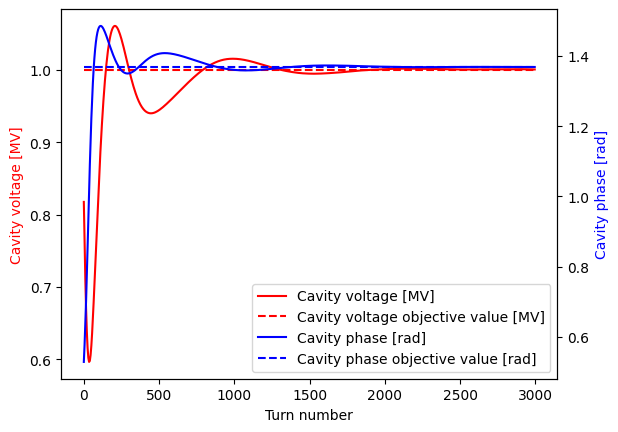

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", show_objective=True)

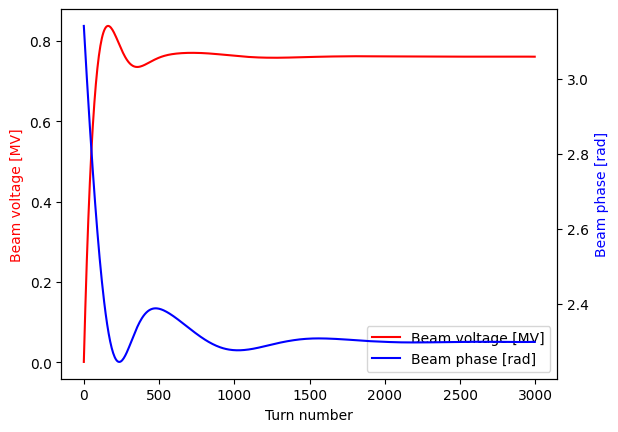

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", phasor="beam")

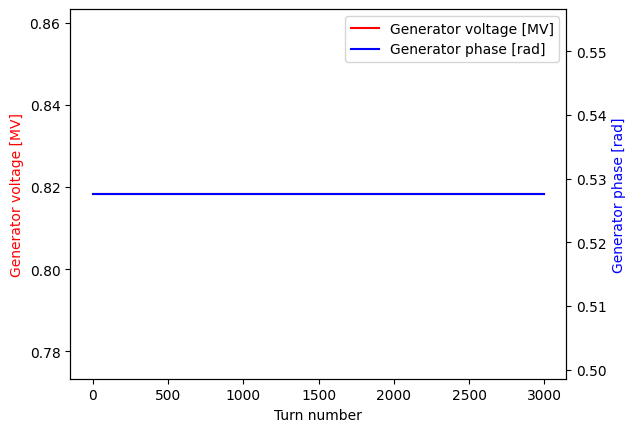

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", phasor="generator")

## With beam and phasor initialization

To speed up the beam loading build-up, it is possible to use the `CavityResonator.init_phasor` method to initialize the `CavityResonator.beam_phasor` to its equilibrium value corresponding to a given beam distribution:

In [ ]:
mybeam, MC, MCmon = restart(I0=0.2, tot_turns=500)

In [ ]:
MC.init_phasor(mybeam)

In [ ]:
for i in tqdm(range(500)):
  long.track(mybeam)
  rad.track(mybeam)
  MC.track(mybeam)
  MCmon.track(mybeam, MC)
meanVc = np.mean(MC.cavity_phasor_record)
print(f"\n Residual error: amplitude {np.round((1-np.abs(meanVc)/MC.Vc)*100,3)} % & phase {np.round((1-np.angle(meanVc)/MC.theta)*100,3)} %")

100%|██████████| 500/500 [00:09<00:00, 54.40it/s]


 Residual error: amplitude 0.1 % & phase -0.113 %


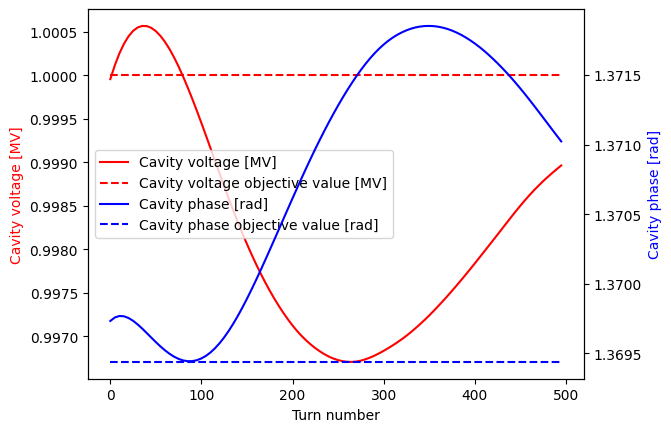

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", show_objective=True)

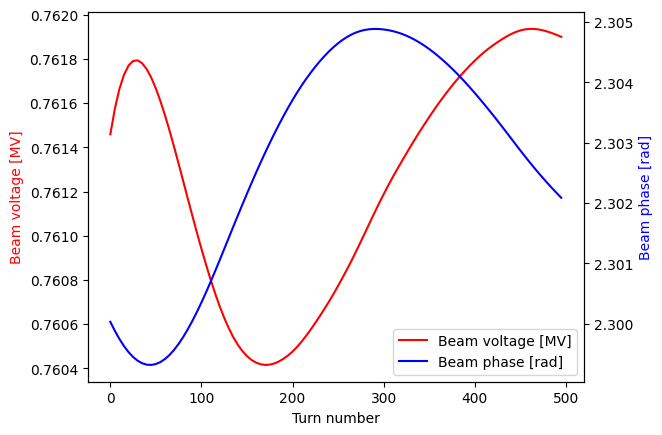

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", phasor="beam")

# CavityResonator interface for loops and feedbacks

The different types of loop or feedback to be applied to `CavityResonator` objects are defined as separate classes, they must be initialised separately after the `CavityResonator` object.

The loop must then be added to the CavityResonator object using:

`CavityResonator.feedback.append(loop)`

The `CavityResonator.feedback` interface is just a `list` which contains all the different kinds of feedback applied to this `CavityResonator` object. Once a feedback has been added to this list, its `track` method will automatically be called when then `CavityResonator.track` method is called.

# ProportionalLoop class

The `ProportionalLoop` is a **simple proportional feedback loop** to control a `CavityResonator` amplitude and phase.
It takes as input:
+ `gain_A` an amplitude (voltage) gain.
+ `gain_P` a phase gain.
+ `delay` the feedback delay in unit of turns.

The feedback setpoints are `CavityResonator.Vc` and `CavityResonator.theta` and the loop modifies the generator amplitude `CavityResonator.Vg` and phase `CavityResonator.theta_g` according to:
+ `Vg -= gain_A*(cavity_voltage - Vc)`
+ `theta_g -= gain_P*(cavity_phase - theta)`

The generator modification is applied after `delay` revolution periods.

In [ ]:
from mbtrack2 import ProportionalLoop

## Step without beam

The `ProportionalLoop` can be used to perform a step increase of the cavity voltage and phase.



In [ ]:
mybeam, MC, MCmon = restart(I0=0.001, tot_turns=500)

In [ ]:
MC.feedback

[]

`MC.feedback` is empty, let us define a `ProportionalLoop` object and adds it to `MC`:

In [ ]:
PL = ProportionalLoop(ring, MC, gain_A=0.1, gain_P=0.1, delay=5)

In [ ]:
MC.feedback.append(PL)

In [ ]:
MC.feedback

Here the objective voltage `MC.Vc` is increased to 1.05 MV at turn 250, the objective phase `MC.theta` is changed accordingly to keep energy balance:

In [ ]:
for i in tqdm(range(500)):
  MC.track(mybeam)
  MCmon.track(mybeam, MC)
  if i == 250:
    MC.Vc = 1.05e6
    MC.theta = np.arccos(ring.U0/MC.Vc)
meanVc = np.mean(MC.cavity_phasor_record)
print(f"\n Residual error: amplitude {np.round((1-np.abs(meanVc)/MC.Vc)*100,3)} % & phase {np.round((1-np.angle(meanVc)/MC.theta)*100,3)} %")

100%|██████████| 500/500 [00:06<00:00, 74.47it/s]


 Residual error: amplitude 0.0 % & phase -0.0 %


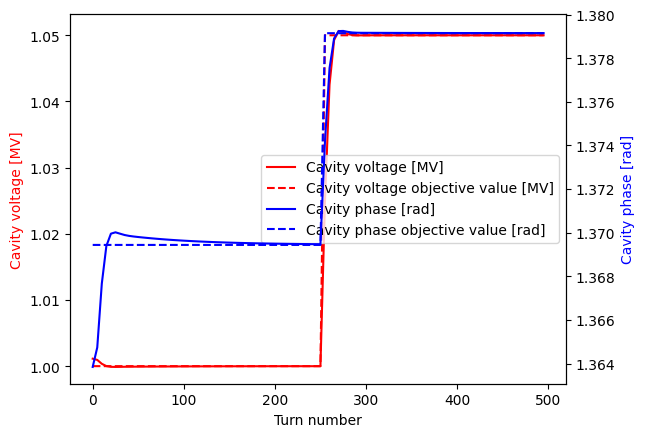

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", show_objective=True)

We can see that the generator voltage `MC.Vg` and phase `MC.theta_g` is changed by the `ProportionalLoop` during the tracking:

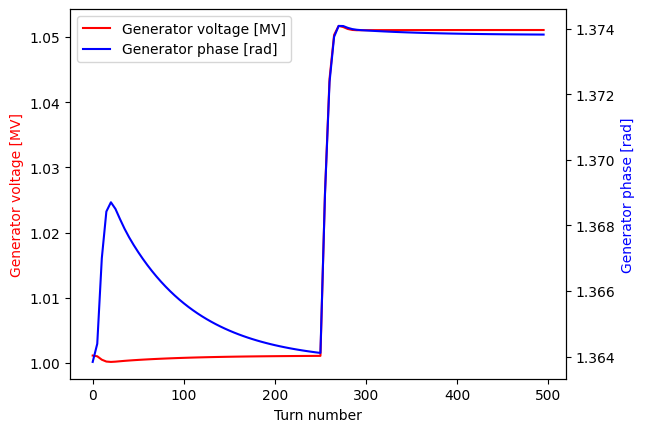

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", phasor="generator")

## Step with beam

The same step with a 200 mA beam is shown bellow:

In [ ]:
mybeam, MC, MCmon = restart(I0=0.2, tot_turns=1000)
MC.init_phasor(mybeam)

In [ ]:
PL = ProportionalLoop(ring, MC, gain_A=0.1, gain_P=0.1, delay=5)
MC.feedback.append(PL)

In [ ]:
for i in tqdm(range(1000)):
  long.track(mybeam)
  rad.track(mybeam)
  MC.track(mybeam)
  MCmon.track(mybeam, MC)
  if i == 250:
    MC.Vc = 1.05e6
    MC.theta = np.arccos(ring.U0/MC.Vc)
meanVc = np.mean(MC.cavity_phasor_record)
print(f"\n Residual error: amplitude {np.round((1-np.abs(meanVc)/MC.Vc)*100,3)} % & phase {np.round((1-np.angle(meanVc)/MC.theta)*100,3)} %")

100%|██████████| 1000/1000 [00:17<00:00, 56.14it/s]


 Residual error: amplitude -0.031 % & phase -0.061 %


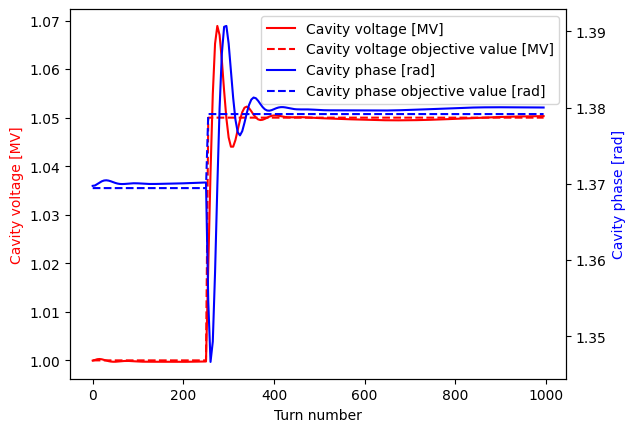

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", show_objective=True)

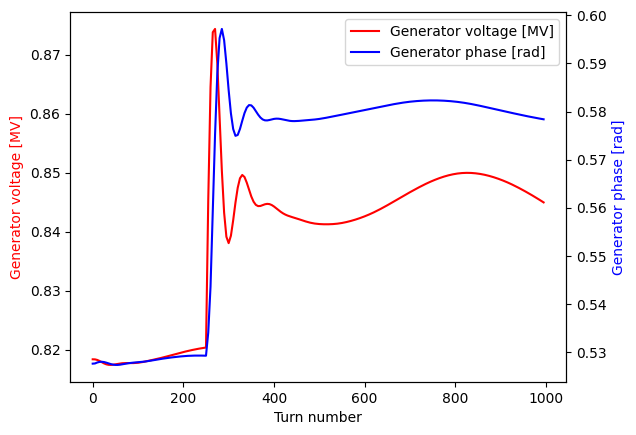

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", phasor="generator")

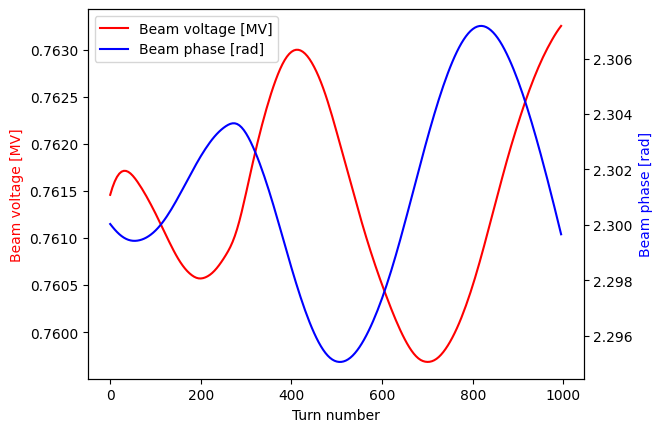

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", phasor="beam")

# ProportionalIntegralLoop class

The `ProportionalIntegralLoop` is a **more realistic Proportional Integral (PI) loop** to control a `CavityResonator` amplitude and phase via generator current `Ig` to take into account the cavity response [1].

The basic idea of a PI controller is described here: https://en.wikipedia.org/wiki/PID_controller

The `ProportionalIntegralLoop` should be **initialized only after generator
parameters are set**.

The `ProportionalIntegralLoop` important inputs are:
+ `gain` a list of two float like `[Pain, Igain]`, corresponding to the proportional gain `Pain` and integral gain `Igain` of the feedback.
+ `sample_num`, the number of bunch over which the cavity amplitude and phase is computed (in unit of bucket number).
+ `every`, the time interval between two cavity voltage monitoring and feedback in unit of bucket number. This corresponds to the update rate of the feedback.
+ `delay` the loop delay in unit of bucket number.

The feedback setpoints are `CavityResonator.Vc` and `CavityResonator.theta` and the loop modifies the generator amplitude `CavityResonator.Vg` and phase `CavityResonator.theta_g`.

---

During the `CavityResonator.track` call, at each `every` RF bucket:
+ The `cavity_phasor` is computed as the mean over `sample_num` buckets.
+ The following calculation are done:
  + `diff = (Vc*exp(1j*theta) - cavity_phasor) - FFconst` where `FFconst` is the feedfoward constant.
  + `I_record = I_record + diff/fRF` where `fRF` is the RF frequency.
  + `FB_val = Pain * diff + Igain * I_record`
  + `Ig = Vg2Ig(FB_val) + FFconst` where `Vg2Ig` is a function to go from generator voltage to generator current.
+ `Ig` is applied after `delay` RF buckets.
+ `Ig` is then transformed back to generator voltage and modifies `Vg` and `theta_g`.

See [1] for the description on how to go from `Ig` to `Vg` and opposite.

---

Typical gain values:
+ For normal conducting cavities (QL~1e4), a Pgain of ~1.0 and
Igain of ~1e4(5) are usually used.
+ For super conducting cavity (QL > 1e6), a Pgain of ~100
can be used.

In a "bad" parameter set, an unstable oscillation of the cavity voltage
can be caused. So, a parameter scan of the gain should be made.


Some example parameters for KEK-PF:

FPGA-based LLRF controller, IQ sampling using 8 rf waves, output signal in 77-MHz, around 1us system delay
*   E0=2.5GeV, C=187m, frf=500MHz
*   QL=11800, fs0=23kHz
*   ==> gain=[0.5,1e4], sample_num=8, every=7(13ns), delay=500(1us)

In [ ]:
from mbtrack2 import ProportionalIntegralLoop

## Step without beam

The same voltage step is applied using the `ProportionalIntegralLoop` without beam:

In [ ]:
mybeam, MC, MCmon = restart(I0=0.001, tot_turns=5000)
MC.init_phasor(mybeam)

In [ ]:
PIL = ProportionalIntegralLoop(ring, MC, gain=[1.5, 2e4], sample_num=5, every=5, delay=0)
MC.feedback.append(PIL)

In [ ]:
for i in tqdm(range(5000)):
  MC.track(mybeam)
  MCmon.track(mybeam, MC)
  if i == 250:
    MC.Vc = 1.05e6
    MC.theta = np.arccos(ring.U0/MC.Vc)
meanVc = np.mean(MC.cavity_phasor_record)
print(f"\n Residual error: amplitude {np.round((1-np.abs(meanVc)/MC.Vc)*100,3)} % & phase {np.round((1-np.angle(meanVc)/MC.theta)*100,3)} %")

100%|██████████| 5000/5000 [01:15<00:00, 66.30it/s]


 Residual error: amplitude -0.126 % & phase 0.039 %


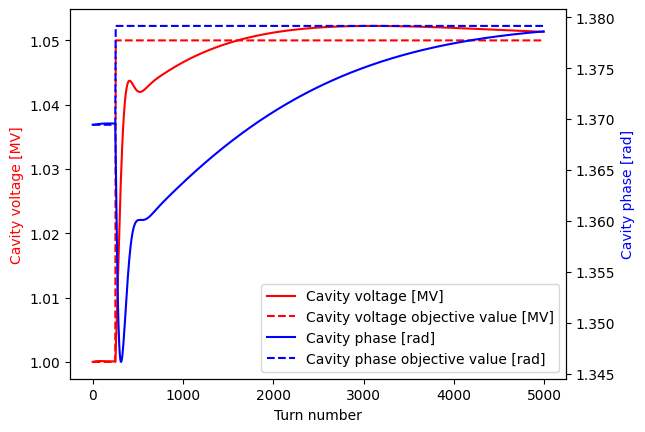

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", show_objective=True)

The current generator phasor `Ig` is changed by the `ProportionalIntegralLoop` during the tracking:

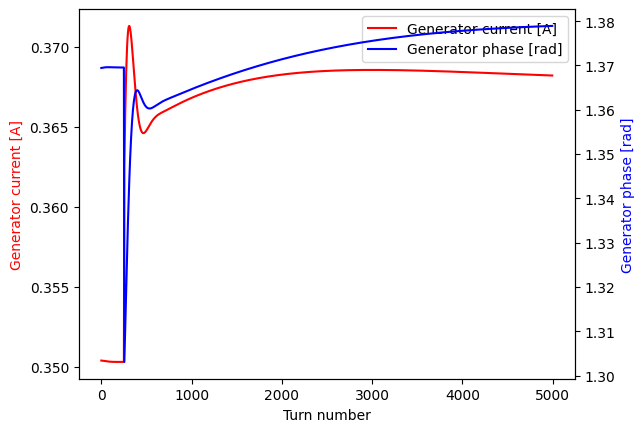

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", phasor="ig")

Which induces changes to the generator voltage and phase:

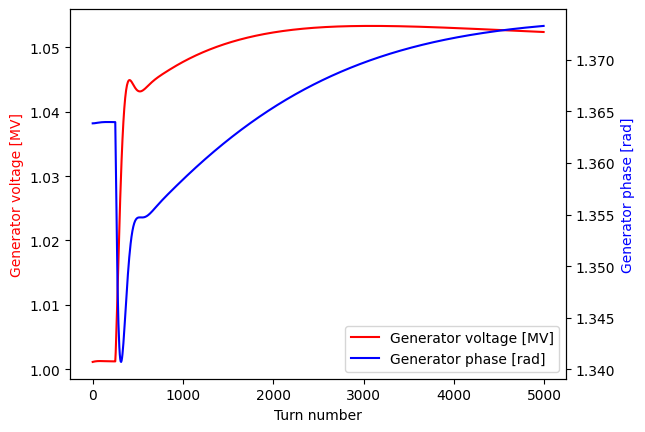

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", phasor="generator")

## Step with beam

And now with a 200 mA beam:

In [ ]:
mybeam, MC, MCmon = restart(I0=0.2, tot_turns=5000)
MC.init_phasor(mybeam)

In [ ]:
PIL = ProportionalIntegralLoop(ring, MC, gain=[1.5, 2e4], sample_num=5, every=5, delay=0)
MC.feedback.append(PIL)

In [ ]:
for i in tqdm(range(5000)):
  long.track(mybeam)
  rad.track(mybeam)
  MC.track(mybeam)
  MCmon.track(mybeam, MC)
  if i == 250:
    MC.Vc = 1.05e6
    MC.theta = np.arccos(ring.U0/MC.Vc)
meanVc = np.mean(MC.cavity_phasor_record)
print(f"\n Residual error: amplitude {np.round((1-np.abs(meanVc)/MC.Vc)*100,3)} % & phase {np.round((1-np.angle(meanVc)/MC.theta)*100,3)} %")

100%|██████████| 5000/5000 [01:28<00:00, 56.52it/s]


 Residual error: amplitude 0.283 % & phase 0.13 %


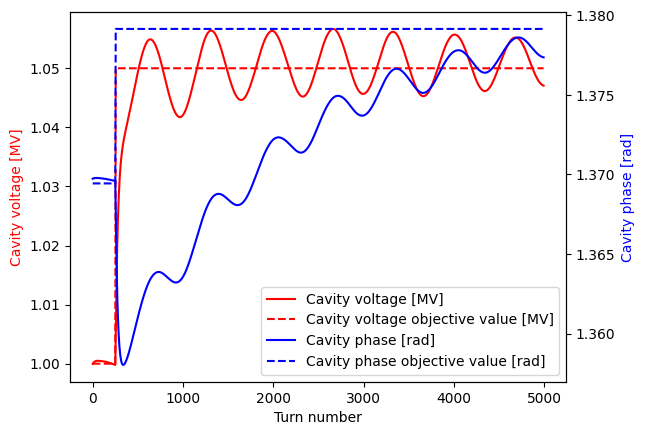

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", show_objective=True)

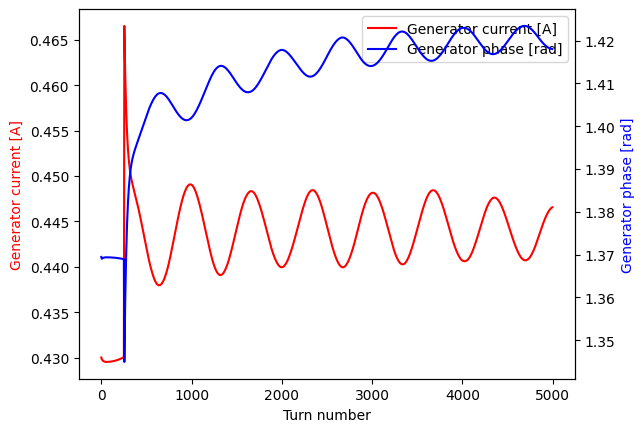

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", phasor="ig")

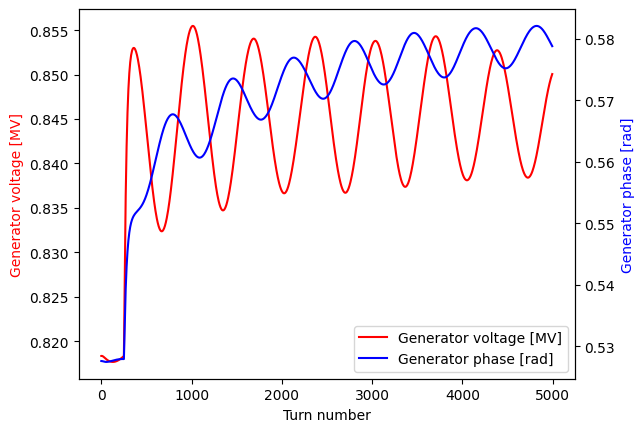

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", phasor="generator")

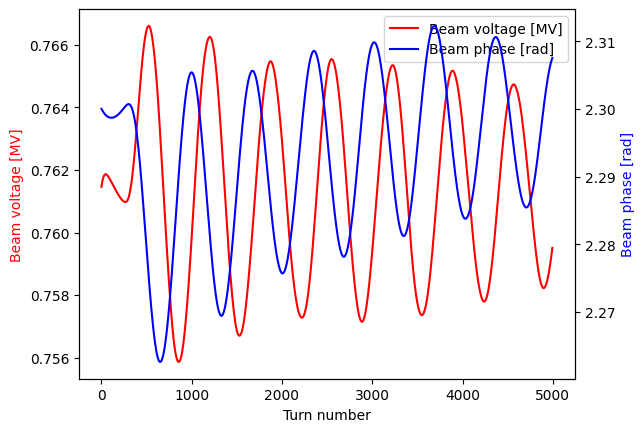

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", phasor="beam")

# TunerLoop

The `TunerLoop` is used to control a `CavityResonator` tuning (`CavityResonator.psi` or `CavityResonator.detune`) in order to **keep the phase between cavity and generator current constant**.

The `TunerLoop` keeps the relation `cavity_phase - theta_g + psi = offset` constant using a proportional controller.

The important inputs of `TunerLoop` are:
+ `gain`, proportional gain of the tuner loop.
+ `avering_period`, period during which the phase difference is monitored and averaged. Then the feedback correction is applied every `avering_period` turn. A value longer than one synchrotron period is recommended.
+ `offset`, the tuning offset in [rad].


In [ ]:
from mbtrack2 import TunerLoop

## Current ramp-up

The `TunerLoop` can be used to keep the relation `cavity_phase - theta_g + psi = offset` constant during a current ramp-up from 200 mA to 210 mA:

In [ ]:
mybeam, MC, MCmon = restart(I0=0.2, tot_turns=3000)
MC.init_phasor(mybeam)

In [ ]:
nus = ring.synchrotron_tune(1.0e6) # synchrotron tune
Ts = 1/nus # synchrotron period in turns

In [ ]:
Ts

693.5479215314126

In [ ]:
TL = TunerLoop(ring, MC, gain=0.2, avering_period=Ts, offset=0)
MC.feedback.append(TL)

In [ ]:
for i in tqdm(range(3000)):
  long.track(mybeam)
  rad.track(mybeam)
  MC.track(mybeam)
  MCmon.track(mybeam, MC)
  if i == 500:
    for i in range(ring.h):
      mybeam[i].current=mybeam[i].current*1.05 # 5 % current increase
meanVc = np.mean(MC.cavity_phasor_record)
print(f"\n Residual error: amplitude {np.round((1-np.abs(meanVc)/MC.Vc)*100,3)} % & phase {np.round((1-np.angle(meanVc)/MC.theta)*100,3)} %")

100%|██████████| 3000/3000 [01:18<00:00, 38.39it/s]


 Residual error: amplitude -1.699 % & phase -1.144 %


In [ ]:
mybeam.current

0.21000000000000005

Because of the current increase, the beam loading voltage has increased:

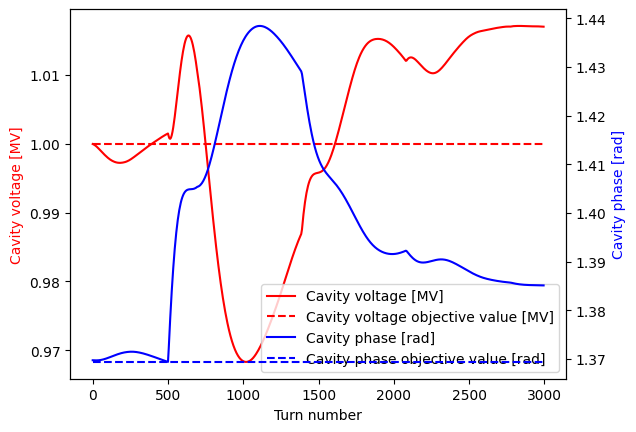

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", show_objective=True)

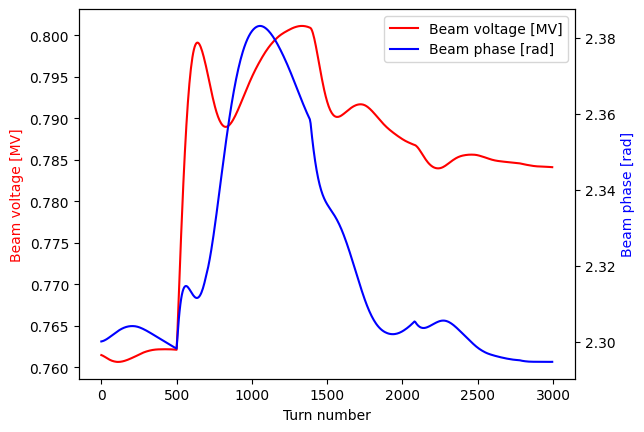

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", phasor="beam")

The cavity tuning angle `CavityResonator.psi` is controlled by the `TunerLoop` to keep the tuner difference constant:

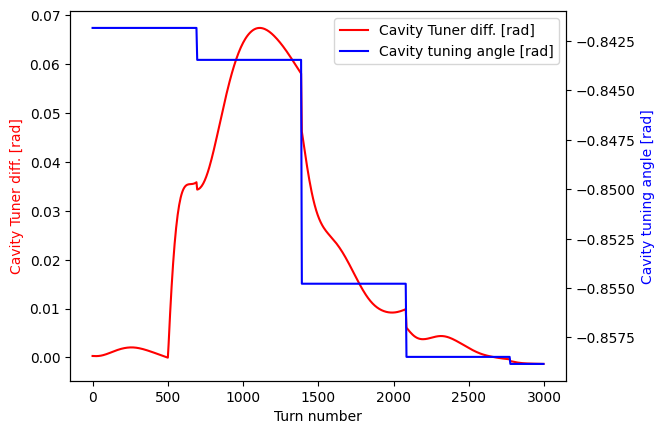

In [ ]:
file = hp.File("save.hdf5", "r")
cavity_data = file["MC"]

time = np.array(cavity_data["time"])
data0 = np.angle(cavity_data["cavity_phasor_record"][0,:])
data1 = np.array(cavity_data["psi"])
data2 = np.array(cavity_data["theta_g"])

ylabel1 = "Cavity Tuner diff. [rad]"
ylabel2 = "Cavity tuning angle [rad]"
fig, ax = plt.subplots()
twin = ax.twinx()
p1, = ax.plot(time, data0-data2+data1, color="r",label=ylabel1)
p2, = twin.plot(time, data1, color="b", label=ylabel2)
ax.set_xlabel("Turn number")
ax.set_ylabel(ylabel1)
twin.set_ylabel(ylabel2)
plots = [p1, p2]
ax.legend(handles=plots, loc="best")
ax.yaxis.label.set_color("r")
twin.yaxis.label.set_color("b")
file.close()

# Current ramp-up with ProportionalIntegralLoop and TunerLoop

To keep both the cavity voltage and tuning constant during a current ramp-up, both `ProportionalIntegralLoop` and `TunerLoop` can be used at the same time:

In [ ]:
mybeam, MC, MCmon = restart(I0=0.2, tot_turns=3000)
MC.init_phasor(mybeam)

In [ ]:
PIL = ProportionalIntegralLoop(ring, MC, gain=[1.5, 2e4], sample_num=5, every=5, delay=0)
MC.feedback.append(PIL)

In [ ]:
TL = TunerLoop(ring, MC, gain=0.2, avering_period=Ts, offset=0)
MC.feedback.append(TL)

In [ ]:
MC.feedback

In [ ]:
for i in tqdm(range(3000)):
  long.track(mybeam)
  rad.track(mybeam)
  MC.track(mybeam)
  MCmon.track(mybeam, MC)
  if i == 500:
    for i in range(ring.h):
      mybeam[i].current=mybeam[i].current*1.05 # 5 % current increase
meanVc = np.mean(MC.cavity_phasor_record)
print(f"\n Residual error: amplitude {np.round((1-np.abs(meanVc)/MC.Vc)*100,3)} % & phase {np.round((1-np.angle(meanVc)/MC.theta)*100,3)} %")

100%|██████████| 3000/3000 [01:17<00:00, 38.62it/s]


 Residual error: amplitude 0.73 % & phase 0.427 %


In [ ]:
mybeam.current

0.21000000000000005

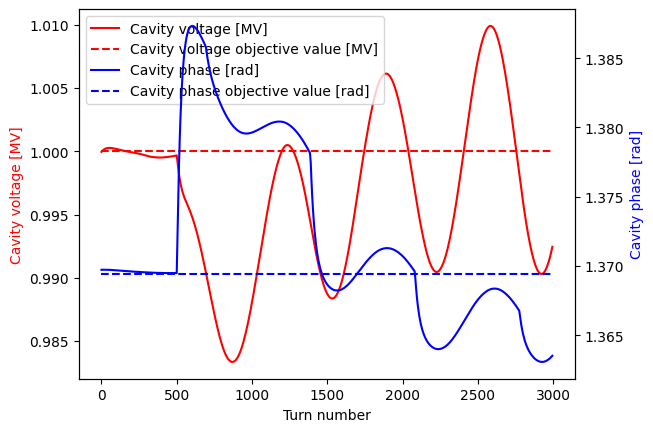

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", show_objective=True)

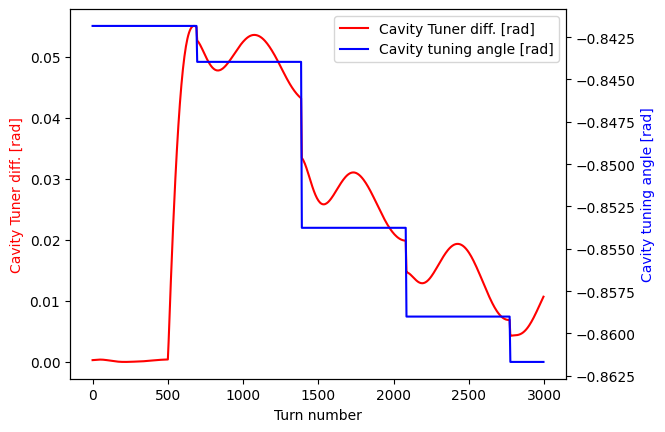

In [ ]:
file = hp.File("save.hdf5", "r")
cavity_data = file["MC"]

time = np.array(cavity_data["time"])
data0 = np.angle(cavity_data["cavity_phasor_record"][0,:])
data1 = np.array(cavity_data["psi"])
data2 = np.array(cavity_data["theta_g"])

ylabel1 = "Cavity Tuner diff. [rad]"
ylabel2 = "Cavity tuning angle [rad]"
fig, ax = plt.subplots()
twin = ax.twinx()
p1, = ax.plot(time, data0-data2+data1, color="r",label=ylabel1)
p2, = twin.plot(time, data1, color="b", label=ylabel2)
ax.set_xlabel("Turn number")
ax.set_ylabel(ylabel1)
twin.set_ylabel(ylabel2)
plots = [p1, p2]
ax.legend(handles=plots, loc="best")
ax.yaxis.label.set_color("r")
twin.yaxis.label.set_color("b")
file.close()

# DirectFeedback

The `DirectFeedback` is a direct RF feedback (DFB) [2,3] aiming to **reduce the effective shunt impedance seen by the beam** to fight against instabilities. It works by using a PI controller via generator current `Ig` to take into account the cavity response [1].

In fact, the `DirectFeedback` inherits from `ProportionalIntegralLoop` so all
mandatory parameters from `ProportionalIntegralLoop` should be passed as
kwargs when initializing a `DirectFeedback` object.

To avoid cavity-beam unmatching (large synchrotron oscilation of beam),
the `CavityResonator` generator parameters should be set before
initialization.

The `DirectFeedback` important inputs are:
+ `DFB_gain` is the DFB gain.
+ `DFB_phase_shift` is the DFB phase shift.
+ `gain`,`sample_num`, `every` and `delay` for the `ProportionalIntegralLoop` must be specified.
+ `DFB_sample_num`, `DFB_every`, `DFB_delay` are analog to their definitions in `ProportionalIntegralLoop` but the `DirectFeedback`. If not specified they take the same values as `sample_num`, `every` and `delay`.

---

The DFB induces a new generator voltage phasor component $\tilde{V}_{g,DFB}$ which tends to reduce the effect of the beam loading, see [2,3] for more details.

During the `CavityResonator.track` call, at each `DFB_every` RF bucket:
+ The `cavity_phasor` is computed as the mean over `DFB_sample_num` buckets.
+ The following calculation are done:
  + `Vg_DFB = DFB_gain * cavity_phasor * exp(1j*DFB_phase_shift)`.
  + `Ig_DFB = Vg2Ig(Vg_DFB)` where `Vg2Ig` is a function to go from generator voltage to generator current.
+ `Ig_DFB` is applied after `DFB_delay` RF buckets.
+ The total `Ig` is then transformed back to generator voltage and modifies `Vg` and `theta_g`.

See [1] for the description on how to go from `Ig` to `Vg` and opposite.

## DC Robinson instability

The DC Robinson instability is a well known instability which leads to a loss of phase focusing if the beam loading voltage is too high compared to the generator voltage.

To illustrate this instability, we can track a 1 A beam and look at the results:

In [ ]:
from mbtrack2 import BeamMonitor, plot_beamdata

In [ ]:
I0 = 1.0
mybeam, MC, MCmon = restart(I0=I0, tot_turns=3000)
MC.init_phasor(mybeam)
beammon = BeamMonitor(ring.h, 10, 1, 300)

Check DC Robinson stability:

In [ ]:
MC.is_DC_Robinson_stable(I0)

False

In [ ]:
for i in tqdm(range(3000)):
  long.track(mybeam)
  rad.track(mybeam)
  MC.track(mybeam)
  MCmon.track(mybeam, MC)
  beammon.track(mybeam)
meanVc = np.mean(MC.cavity_phasor_record)
print(f"\n Residual error: amplitude {np.round((1-np.abs(meanVc)/MC.Vc)*100,3)} % & phase {np.round((1-np.angle(meanVc)/MC.theta)*100,3)} %")

100%|██████████| 3000/3000 [00:57<00:00, 52.02it/s]


 Residual error: amplitude 25.229 % & phase -48.969 %


The beam center of mass goes to infinity very fast in DC Robinson conditions:

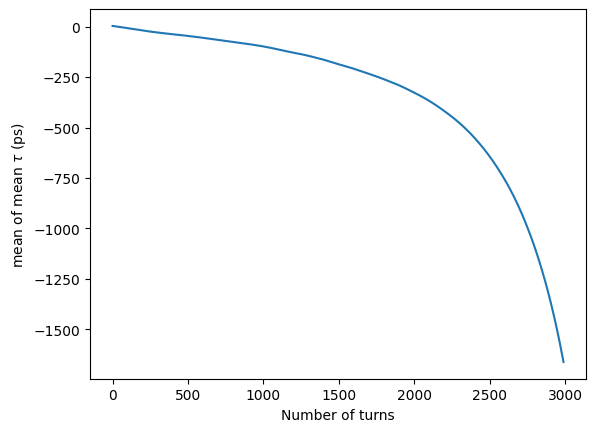

In [ ]:
fig = plot_beamdata("save.hdf5")

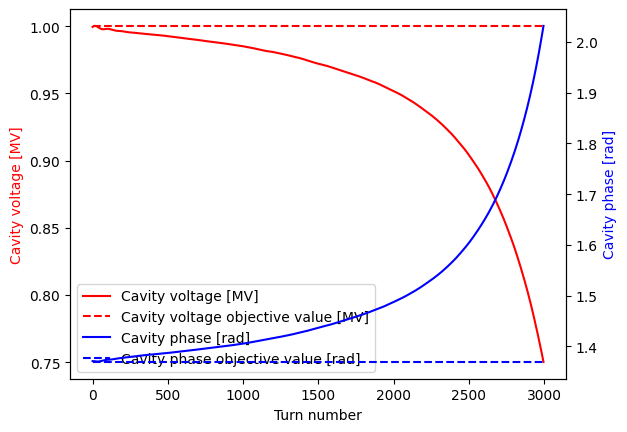

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", show_objective=True)

## With DirectFeedback

With `DirectFeedback`, it is possible to reduce the effective shunt impedance `Rs` seen by the beam to recover stability in the same conditions as before (1 A beam):

In [ ]:
from mbtrack2 import DirectFeedback

In [ ]:
I0 = 1.0
mybeam, MC, MCmon = restart(I0=I0, tot_turns=3000)
MC.init_phasor(mybeam)
beammon = BeamMonitor(ring.h, 10, 1, 300)

In [ ]:
DFB = DirectFeedback(ring=ring, cav_res=MC, gain=[1.5, 2e4], sample_num=5, every=5, delay=0, DFB_gain=0.1, DFB_phase_shift=0, DFB_sample_num=1, DFB_every=1)
MC.feedback.append(DFB)

In [ ]:
MC.Rs*1e-6 # nominal shunt impedance in [Mohm]

20.0

In [ ]:
DFB.DFB_Rs*1e-6 # effective shunt impedance in [Mohm]

19.61676229835558

With the effective shunt impedance, the 1 A beam should be stable:

In [ ]:
MC.Rs = DFB.DFB_Rs
print(MC.is_DC_Robinson_stable(I0))
MC.Rs = 20e6

True


In [ ]:
for i in tqdm(range(3000)):
  long.track(mybeam)
  rad.track(mybeam)
  MC.track(mybeam)
  MCmon.track(mybeam, MC)
  beammon.track(mybeam)
meanVc = np.mean(MC.cavity_phasor_record)
print(f"\n Residual error: amplitude {np.round((1-np.abs(meanVc)/MC.Vc)*100,3)} % & phase {np.round((1-np.angle(meanVc)/MC.theta)*100,3)} %")

100%|██████████| 3000/3000 [00:59<00:00, 50.71it/s]


 Residual error: amplitude -0.911 % & phase -0.34 %


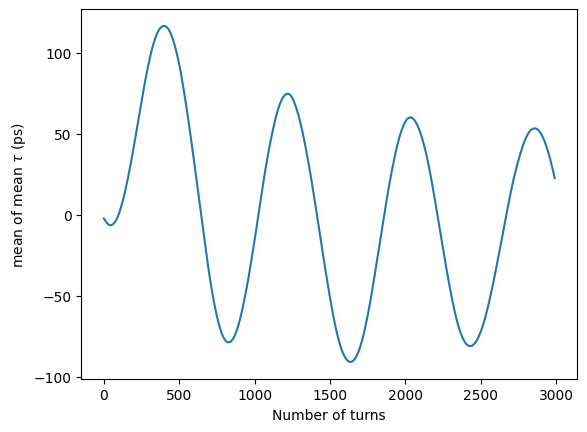

In [ ]:
fig = plot_beamdata("save.hdf5")

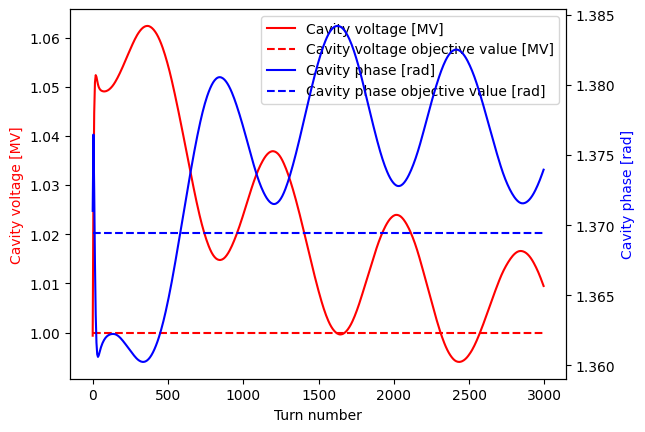

In [ ]:
fig = plot_cavitydata("save.hdf5","MC", show_objective=True)